In [3]:
!pip install --upgrade torch torchvision
!pip install word2number
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report,precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics.pairwise import cosine_similarity
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import os
import glob
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk import pos_tag
import itertools
import networkx as nx
from collections import Counter
from textblob import TextBlob

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Wrangling the Billboard Top 100

Consider the data in billboard.csv containing every song to appear on the weekly Billboard Top 100 chart since 1958, up through the middle of 2021. Each row of this data corresponds to a single song in a single week. For our purposes, the relevant columns here are:<br>

performer: who performed the song<br>
song: the title of the song<br>
year: year (1958 to 2021)<br>
week: chart week of that year (1, 2, etc)<br>
week_position: what position that song occupied that week on the Billboard top 100 chart.<br>
Use your skills in data wrangling and plotting to answer the following three questions.<br>

In [5]:
# Importing the data
billboard=pd.read_csv('billboard.csv')

### Understanding the data
<div class="alert alert-block alert-success">Looking at the dimensions of the data as well as the records for one specific randomly chosen song to understand each variable properly

In [6]:
billboard.head()

,Unnamed: 0,url,week_id,week_position,song,performer,song_id,instance,previous_week_position,peak_position,weeks_on_chart,year,week
0,1,http://www.billboard.com/charts/hot-100/1965-0...,7/17/1965,34,Don't Just Stand There,Patty Duke,Don't Just Stand TherePatty Duke,1,45.0,34,4,1965,29
1,2,http://www.billboard.com/charts/hot-100/1965-0...,7/24/1965,22,Don't Just Stand There,Patty Duke,Don't Just Stand TherePatty Duke,1,34.0,22,5,1965,30
2,3,http://www.billboard.com/charts/hot-100/1965-0...,7/31/1965,14,Don't Just Stand There,Patty Duke,Don't Just Stand TherePatty Duke,1,22.0,14,6,1965,31
3,4,http://www.billboard.com/charts/hot-100/1965-0...,8/7/1965,10,Don't Just Stand There,Patty Duke,Don't Just Stand TherePatty Duke,1,14.0,10,7,1965,32
4,5,http://www.billboard.com/charts/hot-100/1965-0...,8/14/1965,8,Don't Just Stand There,Patty Duke,Don't Just Stand TherePatty Duke,1,10.0,8,8,1965,33


In [7]:
billboard.shape

(327895, 13)

In [8]:
billboard['week_id'].unique().size

3279

In [9]:
billboard[billboard['song']=="whoknows"]

,Unnamed: 0,url,week_id,week_position,song,performer,song_id,instance,previous_week_position,peak_position,weeks_on_chart,year,week
153364,153365,http://www.billboard.com/charts/hot-100/2004-0...,4/24/2004,75,whoknows,Musiq,whoknowsMusiq,1,NaN,75,1,2004,17
153365,153366,http://www.billboard.com/charts/hot-100/2004-0...,5/1/2004,69,whoknows,Musiq,whoknowsMusiq,1,75.0,69,2,2004,18
153366,153367,http://www.billboard.com/charts/hot-100/2004-0...,5/8/2004,65,whoknows,Musiq,whoknowsMusiq,1,69.0,65,3,2004,19
153367,153368,http://www.billboard.com/charts/hot-100/2004-0...,5/15/2004,72,whoknows,Musiq,whoknowsMusiq,1,65.0,65,4,2004,20
153368,153369,http://www.billboard.com/charts/hot-100/2004-0...,5/22/2004,72,whoknows,Musiq,whoknowsMusiq,1,72.0,65,5,2004,21
153369,153370,http://www.billboard.com/charts/hot-100/2004-0...,5/29/2004,85,whoknows,Musiq,whoknowsMusiq,1,72.0,65,6,2004,22
153370,153371,http://www.billboard.com/charts/hot-100/2004-0...,6/5/2004,86,whoknows,Musiq,whoknowsMusiq,1,85.0,65,7,2004,23
153371,153372,http://www.billboard.com/charts/hot-100/2004-0...,6/12/2004,92,whoknows,Musiq,whoknowsMusiq,1,86.0,65,8,2004,24
153372,153373,http://www.billboard.com/charts/hot-100/2004-0...,6/19/2004,99,whoknows,Musiq,whoknowsMusiq,1,92.0,65,9,2004,25
153373,153374,http://www.billboard.com/charts/hot-100/2004-0...,6/26/2004,92,whoknows,Musiq,whoknowsMusiq,1,99.0,65,10,2004,26


**Part A**: Make a table of the top 10 most popular songs since 1958, as measured by the total number of weeks that a song spent on the Billboard Top 100. Note that these data end in week 22 of 2021, so the most popular songs of 2021 will not have up-to-the-minute data; please send our apologies to The Weeknd. <br>

Your table should have 10 rows and 3 columns: performer, song, and count, where count represents the number of weeks that song appeared in the Billboard Top 100. Make sure the entries are sorted in descending order of the count variable, so that the more popular songs appear at the top of the table. Give your table a short caption describing what is shown in the table.<br>

(Note: you'll want to use both performer and song in any group_by operations, to account for the fact that multiple unique songs can share the same title.)

In [10]:
# Get each unique combination of song and performer using groupby and find out how many times it appears in the data
# This tells us how many times this song appeared on the Billboard Top 100
top_songs=billboard.groupby(['song','performer']).size()

# Sort by count values in descending order and keep the top 10 rows
top_10_songs=top_songs.sort_values(ascending=False).head(10)

# Convert to a dataframe
top_10_songs=pd.DataFrame(top_10_songs, columns=['count']).reset_index()
top_10_songs

,song,performer,count
0,Radioactive,Imagine Dragons,87
1,Sail,AWOLNATION,79
2,I'm Yours,Jason Mraz,76
3,Blinding Lights,The Weeknd,76
4,How Do I Live,LeAnn Rimes,69
5,Party Rock Anthem,LMFAO Featuring Lauren Bennett & GoonRock,68
6,Counting Stars,OneRepublic,68
7,Foolish Games/You Were Meant For Me,Jewel,65
8,Rolling In The Deep,Adele,65
9,Before He Cheats,Carrie Underwood,64


**Part B:** Is the "musical diversity" of the Billboard Top 100 changing over time? Let's find out. We'll measure the musical diversity of given year as the number of unique songs that appeared in the Billboard Top 100 that year. Make a line graph that plots this measure of musical diversity over the years. The x axis should show the year, while the y axis should show the number of unique songs appearing at any position on the Billboard Top 100 chart in any week that year. For this part, please filter the data set so that it excludes the years 1958 and 2021, since we do not have complete data on either of those years. Give the figure an informative caption in which you explain what is shown in the figure and comment on any interesting trends you see.

There are number of ways to accomplish the data wrangling here. For example, you could use two distinct sets of data-wrangling steps. The first set of steps would get you a table that counts the number of times that a given song appears on the Top 100 in a given year. The second set of steps operate on the result of the first set of steps; it would count the number of unique songs that appeared on the Top 100 in each year, irrespective of how many times it had appeared.

In [11]:
pd.set_option('display.max_rows', None)

# Grouping the data by year, song, and performer, and then counting the number of unique combinations
# Using both songs and performers to get distinct songs as recommended in Part A
diversity= billboard.groupby(['year', 'song', 'performer']).size().reset_index(name='count')

# Grouping again by year to get the total number of unique combinations of songs and performers for each year
diversity_year = diversity.groupby('year')['count'].count().reset_index()

# Renaming the columns for clarity
diversity_year.columns = ['year', 'number of unique songs']

# Remove the years 1958 and 2021
diversity_year=diversity_year[~diversity_year['year'].isin([1958,2021])]

diversity_year

,year,number of unique songs
1,1959,663
2,1960,700
3,1961,779
4,1962,768
5,1963,754
6,1964,811
7,1965,800
8,1966,832
9,1967,827
10,1968,772


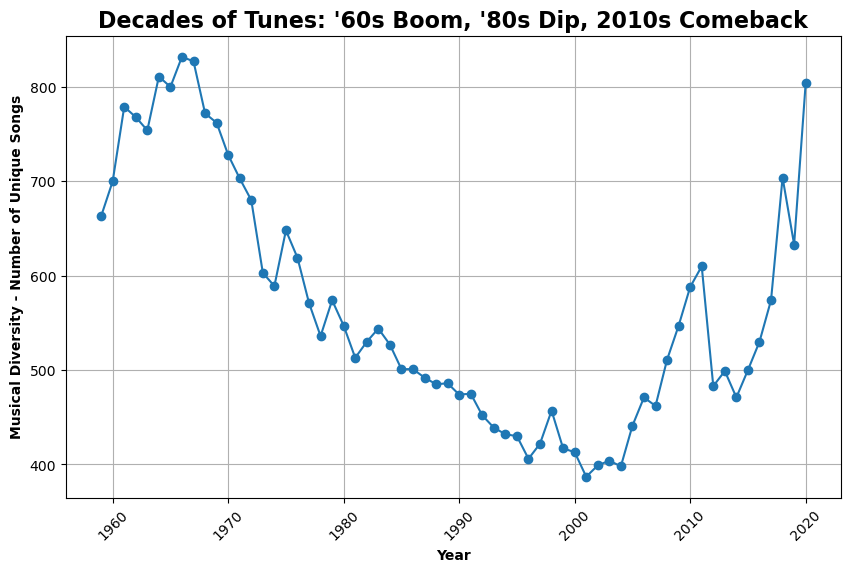

In [12]:
# Plotting the line graph for musical diversity over the years
plt.figure(figsize=(10, 6))
plt.plot(diversity_year['year'], diversity_year['number of unique songs'], marker='o', linestyle='-')
plt.xlabel('Year',fontdict={'weight': 'bold'})
plt.ylabel('Musical Diversity - Number of Unique Songs',fontdict={'weight': 'bold'})
plt.title("Decades of Tunes: '60s Boom, '80s Dip, 2010s Comeback",fontdict={'weight': 'bold', 'size': 16})
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

<div class="alert alert-block alert-success">
Trends and Insights from the data: <br>
    
 - **'60s Surge:** From 1959 to the mid-1960s, there's a clear rise in musical diversity, likely driven by cultural shifts and the emergence of genres like rock 'n' roll.

 - **Decades of Decline:** Post the mid-1960s peak, there's a gradual decline until the late 1980s. Industry consolidation and genre saturation might explain this trend.

 - **Stable Late 20th Century:** The period from the late '80s to early 2000s shows relative stability in song diversity, reflecting the mainstream dominance of genres like pop and hip-hop.

 - **Digital Boost:** Sporadic peaks in the 2000s align with the rise of digital music platforms, making production and distribution more accessible.

 - **Late 2010s Revival:** A notable increase in musical diversity from the late 2010s into 2020 can be attributed to platforms like Spotify and YouTube, democratizing music creation and sharing.

**Part C:** Let's define a "ten-week hit" as a single song that appeared on the Billboard Top 100 for at least ten weeks. There are 19 artists in U.S. musical history since 1958 who have had at least 30 songs that were "ten-week hits." Make a bar plot for these 19 artists, showing how many ten-week hits each one had in their musical career. Give the plot an informative caption in which you explain what is shown.

Notes:

You might find this easier to accomplish in two distinct sets of data wrangling steps.
Make sure that the individuals names of the artists are readable in your plot, and that they're not all jumbled together. If you find that your plot isn't readable with vertical bars, you can add a coord_flip() layer to your plot to make the bars (and labels) run horizontally instead.
By default a bar plot will order the artists in alphabetical order. This is acceptable to turn in. But if you'd like to order them according to some other variable, you can use the fct_reorder function, described in this blog post. This is optional.

In [13]:
# Perform the previous steps as you've done before
twh = billboard.groupby(['song', 'performer'])['week_id'].count().reset_index(name='count of weeks')
twh = twh[twh['count of weeks'] >= 10]
twh = twh.groupby('performer')['song'].count().reset_index(name='count of ten-week hits')

# Filter for performers who had at least 30 songs that were ten-week hits
twh_performers = twh[twh['count of ten-week hits'] >= 30].reset_index()

# Keep only 'performer' and 'count of ten-week hits' columns
twh_performers = twh_performers[['performer', 'count of ten-week hits']].sort_values(by='count of ten-week hits', ascending=False)

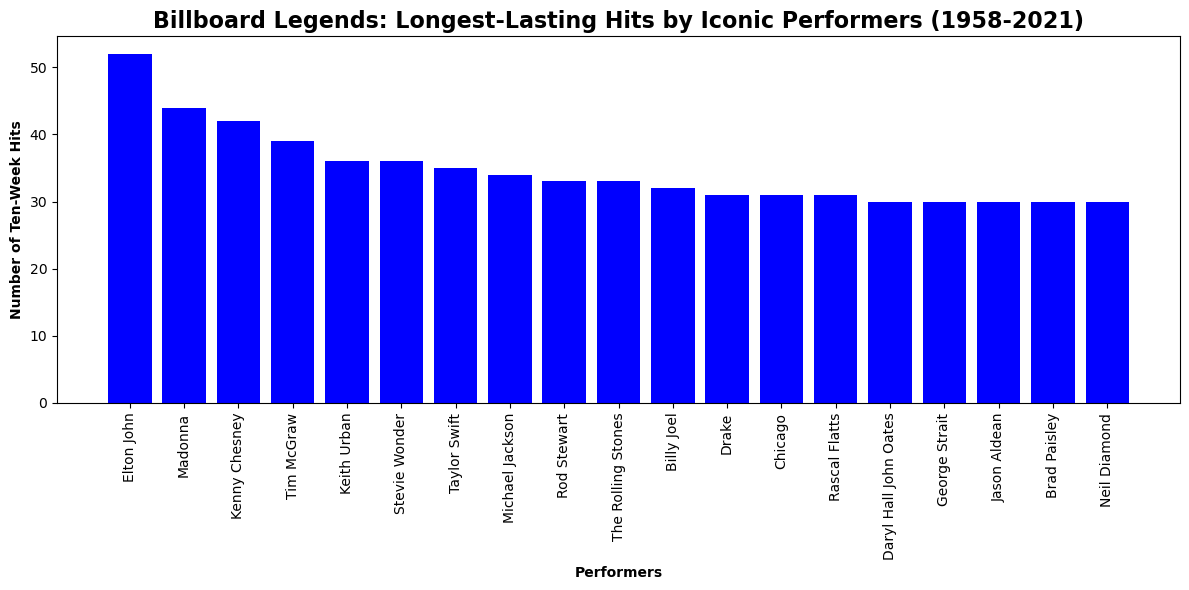

In [14]:
# Create the bar plot
plt.figure(figsize=(12, 6))
plt.bar(twh_performers['performer'], twh_performers['count of ten-week hits'], color='b')
plt.xlabel('Performers',fontdict={'weight': 'bold'})
plt.ylabel('Number of Ten-Week Hits',fontdict={'weight': 'bold'})
plt.title("Billboard Legends: Longest-Lasting Hits by Iconic Performers (1958-2021)",fontdict={'weight': 'bold', 'size': 16})
plt.xticks(rotation=90)
plt.tight_layout()

# Show the plot
plt.show()